## Neural Networks - Sentiment Analysis

In [1]:
#Installing transformers
#!pip install simpletransformers==0.60.9
!pip install simpletransformers

     |████████████████████████████████| 249 kB 28.5 MB/s 
     |████████████████████████████████| 1.2 MB 69.2 MB/s 
     |████████████████████████████████| 6.6 MB 69.9 MB/s 
     |████████████████████████████████| 10.1 MB 69.3 MB/s 
     |████████████████████████████████| 4.0 MB 59.7 MB/s 
     |████████████████████████████████| 325 kB 70.3 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 1.8 MB 59.5 MB/s 
     |████████████████████████████████| 596 kB 66.1 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 895 kB 72.7 MB/s 
     |████████████████████████████████| 144 kB 74.3 MB/s 
     |████████████████████████████████| 181 kB 75.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 52.6 MB/s 
     |████████████████████████████████| 136 kB 50.8 MB/s 
     |████████████████████████████████| 212 kB 55.0 MB/s 
     |█████████████

In [26]:
#Importing libraries
import pandas as pd
import sklearn
from sklearn.metrics import f1_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import matplotlib.pyplot as plt 
import seaborn as sn

In [27]:
# For using Neural models in GoogleColab:

from google.colab import drive
drive.mount('/content/drive')

!ls drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MyDrive


In [28]:
#Path to access the data from a Google Drive folder
data_path = 'drive/MyDrive/NLP2022/data/OLIDv1.0_sharedtask/olid-training-v1.0.tsv'

In [99]:
#We create training and validation set to perform the analysis
train = pd.read_csv(data_path, delimiter='\t', encoding='utf-8')
train.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [100]:
train.rename({'tweet': 'text', 'subtask_a': 'label'}, axis=1, inplace=True) # rename columns if necessary
train['target'] = train.label.map({'NOT':0, 'OFF':1}) # convert label to a numerical variable
train.drop(['subtask_b', 'subtask_c'], axis=1, inplace=True) # drop irrelevant columns
train.head()

#create a copy of the original data to work with 
df = train.copy()
df.head()

,id,text,label,target
0,86426,@USER She should ask a few native Americans wh...,OFF,1
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1
2,16820,Amazon is investigating Chinese employees who ...,NOT,0
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0


In [101]:
#Preprocessing of the data. We import nltk and proceed to eliminate stopwords and to leatize the corpus.
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
eng_stops = set(stopwords.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def clean(text):
    # remove all the special characters
    text = re.sub('[^a-zA-Z]', ' ',text) 
    # convert all letters to lower case
    words = text.lower().split()
    # remove stop words
    words = [w for w in words if not w in eng_stops]    
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (' '.join(words))

df['clean'] = df['text'].apply(lambda x: clean(x))
df.head()
#after preprocessing we obtein raw words, leatized without the most commons words in english that don't have semantic value

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,text,label,target,clean
0,86426,@USER She should ask a few native Americans wh...,OFF,1,user ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,1,user user go home drunk user maga trump url
2,16820,Amazon is investigating Chinese employees who ...,NOT,0,amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,1,user someone vetaken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,0,user user obama wanted liberal amp illegals mo...


In [102]:
train = pd.DataFrame({'text': df.clean, 'labels': df.target})
test = pd.DataFrame({'text': df.clean, 'labels': df.target})

In [103]:
train.head()

,text,labels
0,user ask native american take,1
1,user user go home drunk user maga trump url,1
2,amazon investigating chinese employee selling ...,0
3,user someone vetaken piece shit volcano,1
4,user user obama wanted liberal amp illegals mo...,0


In [104]:
from sklearn.model_selection import train_test_split

train, dev = train_test_split(train, test_size=0.1, random_state=42, 
                               stratify=train[['labels']])

In [106]:
print(len(train))
print("train:", train[['labels']].value_counts(sort=False))
train.head(3)

11916
train: labels
0         7956
1         3960
dtype: int64


,text,labels
12900,user think would pick fun,0
10804,user bite transition complete,0
11237,user hol tl see tht big dick energy,1


In [107]:
print(len(dev))
print("dev:", dev[['labels']].value_counts(sort=False))
dev.head(3)

1324
dev: labels
0         884
1         440
dtype: int64


,text,labels
352,user user said always praying even tho anythin...,0
3729,user user user user user user user user user u...,0
12763,user user another dem tactic leftist good cons...,0


In [112]:
#Now we feed the model
model_args = ClassificationArgs()

model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
# model_args.labels_list=["negative", "positive", "neutral"] # list of labels
model_args.evaluate_during_training=True # to perform evaluation while training the model (eval data should be passed to the training method)

# Initial args
model_args.num_train_epochs=6
model_args.train_batch_size=64
model_args.learning_rate=1e-5 
model_args.max_seq_length=128 

# Early stopping to combat overfitting
model_args.use_early_stopping=True
model_args.early_stopping_delta=0.01
model_args.early_stopping_metric='eval_loss'
model_args.early_stopping_metric_minimize=True
model_args.early_stopping_patience=2 #55555555
model_args.evaluate_during_training_steps=32

model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False


# model_args.overwrite_output_dir=True # overwrite existing saved models in the same directory
# model_args.evaluate_during_training=True # to perform evaluation while training the model (eval data should be passed to the training method)

# model_args.num_train_epochs=6
# model_args.train_batch_size=32
# model_args.learning_rate=4e-6  
# model_args.max_seq_length=128 

# # Early stopping to combat overfitting: https://simpletransformers.ai/docs/tips-and-tricks/#using-early-stopping
# model_args.use_early_stopping=True
# model_args.early_stopping_delta=0.01 # "The improvement over best_eval_loss necessary to count as a better checkpoint"
# model_args.early_stopping_metric='eval_loss'
# model_args.early_stopping_metric_minimize=True 
# model_args.early_stopping_patience=2 
# model_args.evaluate_during_training_steps=34 # how often you want to run validation in terms of training steps (or batches)

model_args.evaluate_during_training_silent=False
model_args.evaluate_each_epoch=False

In [113]:
#Selection of classification model
model = ClassificationModel('bert', 'bert-base-cased', num_labels=2, args=model_args, use_cuda=True) 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [114]:
_, history = model.train_model(train, eval_df=dev, f1=sklearn.metrics.f1_score)

  0%|          | 0/11916 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Running Epoch 0 of 6:   0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

Running Epoch 1 of 6:   0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

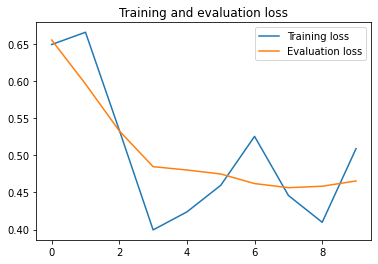

In [115]:
#graphic of the metrics to evaluate performance
train_loss = history['train_loss']
eval_loss = history['eval_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(eval_loss, label='Evaluation loss')
plt.title('Training and evaluation loss')
plt.legend();

In [116]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(dev)
result

  0%|          | 0/1324 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/166 [00:00<?, ?it/s]

{'auprc': 0.7243277876652279,
 'auroc': 0.8442346256684491,
 'eval_loss': 0.4655008660741599,
 'fn': 155,
 'fp': 139,
 'mcc': 0.49519493128642367,
 'tn': 745,
 'tp': 285}

In [120]:
predicted, probabilities = model.predict(dev.text.to_list())
dev['predicted'] = predicted
#obtaining results from test

  0%|          | 0/1324 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

In [121]:
test.head()

,text,labels,predicted
0,user ask native american take,1,0
1,user user go home drunk user maga trump url,1,1
2,amazon investigating chinese employee selling ...,0,0
3,user someone vetaken piece shit volcano,1,1
4,user user obama wanted liberal amp illegals mo...,0,0


In [122]:
F1 = f1_score(test.labels, test.predicted, average='macro')
F1
#obtaining numeric metrics to evaluate

0.7989863704154494